In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
from dotenv import load_dotenv
from googleapiclient.discovery import build

In [2]:
comments_df = pd.read_csv('../data/comments.csv')
replies_df = pd.read_csv('../data/replies.csv')

In [3]:
all_comments_df = pd.concat([comments_df, replies_df], axis=0)

In [4]:
all_comments_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1524 entries, 0 to 957
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   comment         1524 non-null   object 
 1   comment_id      1524 non-null   object 
 2   parent_comment  958 non-null    object 
 3   user            1524 non-null   object 
 4   user_avatar     1524 non-null   object 
 5   user_page       1524 non-null   object 
 6   comment_time    1524 non-null   object 
 7   likes           1524 non-null   int64  
 8   replies         566 non-null    float64
dtypes: float64(1), int64(1), object(7)
memory usage: 119.1+ KB


In [5]:
# replace the NaN's in the reply column with 'n/a' for comments that are comment threads
all_comments_df['parent_comment'] = all_comments_df['parent_comment'].fillna(value='n/a')

In [6]:
# replace the NaN's in the replies column with a value of 0 since these are replies to comments
all_comments_df['replies'] = all_comments_df['replies'].fillna(value=0)

In [7]:
# convert the comment_time column into a datetime format
all_comments_df['comment_time'] = pd.to_datetime(all_comments_df['comment_time'])

In [8]:
# convert certain columns to save space and perform quicker
all_comments_df = all_comments_df.astype({'likes': 'int32', 'replies': 'int32'})

In [9]:
all_comments_df['user'].value_counts()

user
@spider-manunknown9193           47
@Yayofangamer16                  21
@GangsterFrankensteinComputer    19
@arkgaharandan5881               18
@czarnakoza9697                  17
                                 ..
@relhimp                          1
@oodo2908                         1
@anom5389                         1
@jconley2795                      1
@shishkebaba                      1
Name: count, Length: 739, dtype: int64

<Axes: xlabel='comment_time'>

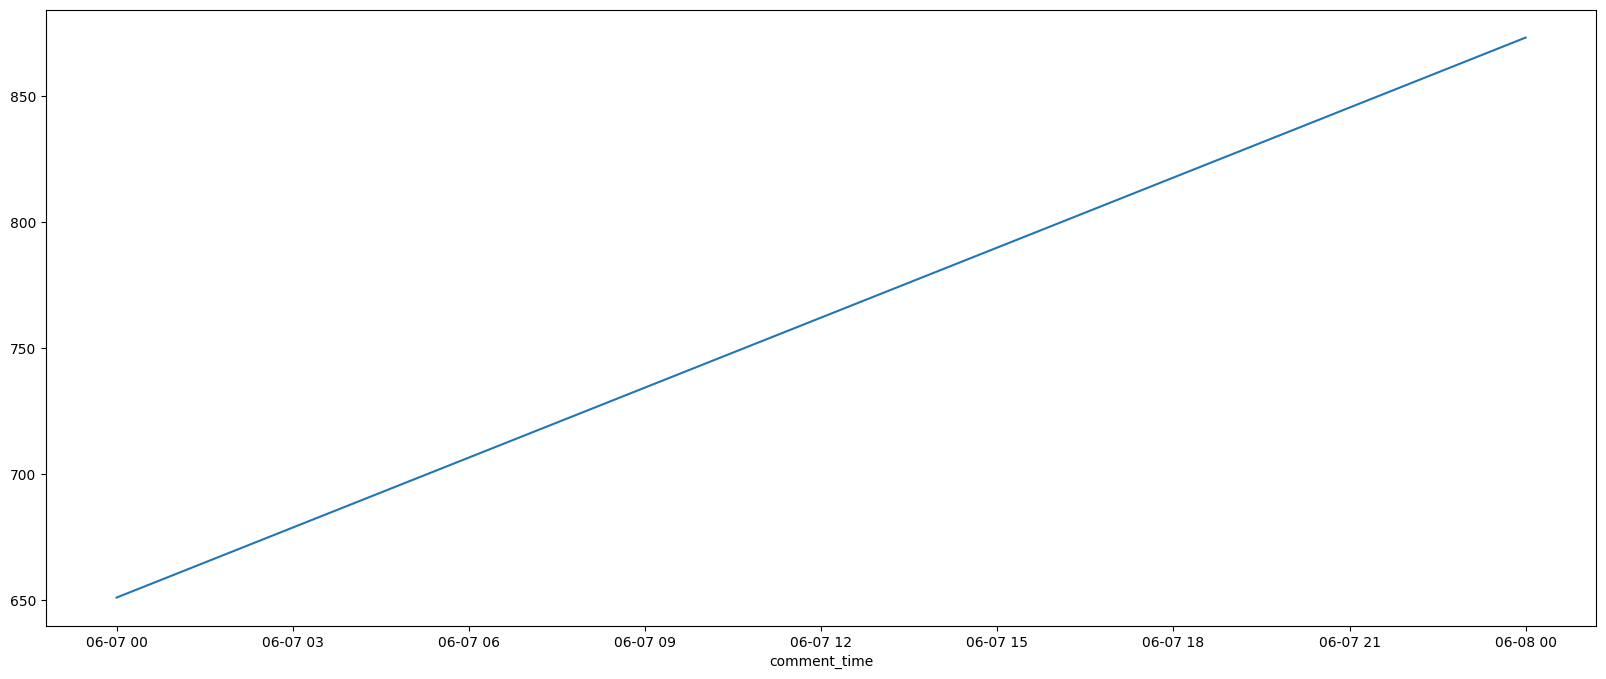

In [10]:
# plot the number of comments made in each day
all_comments_df.groupby(all_comments_df['comment_time'].dt.date).count()['comment'].plot(figsize=(20,8))

C:\Users\Shaief\AppData\Local\Temp\ipykernel_2876\974248026.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  all_comments_df.groupby(all_comments_df['comment_time'].dt.to_period('h')).count()['comment'].plot(figsize=(20,8))


<Axes: xlabel='comment_time'>

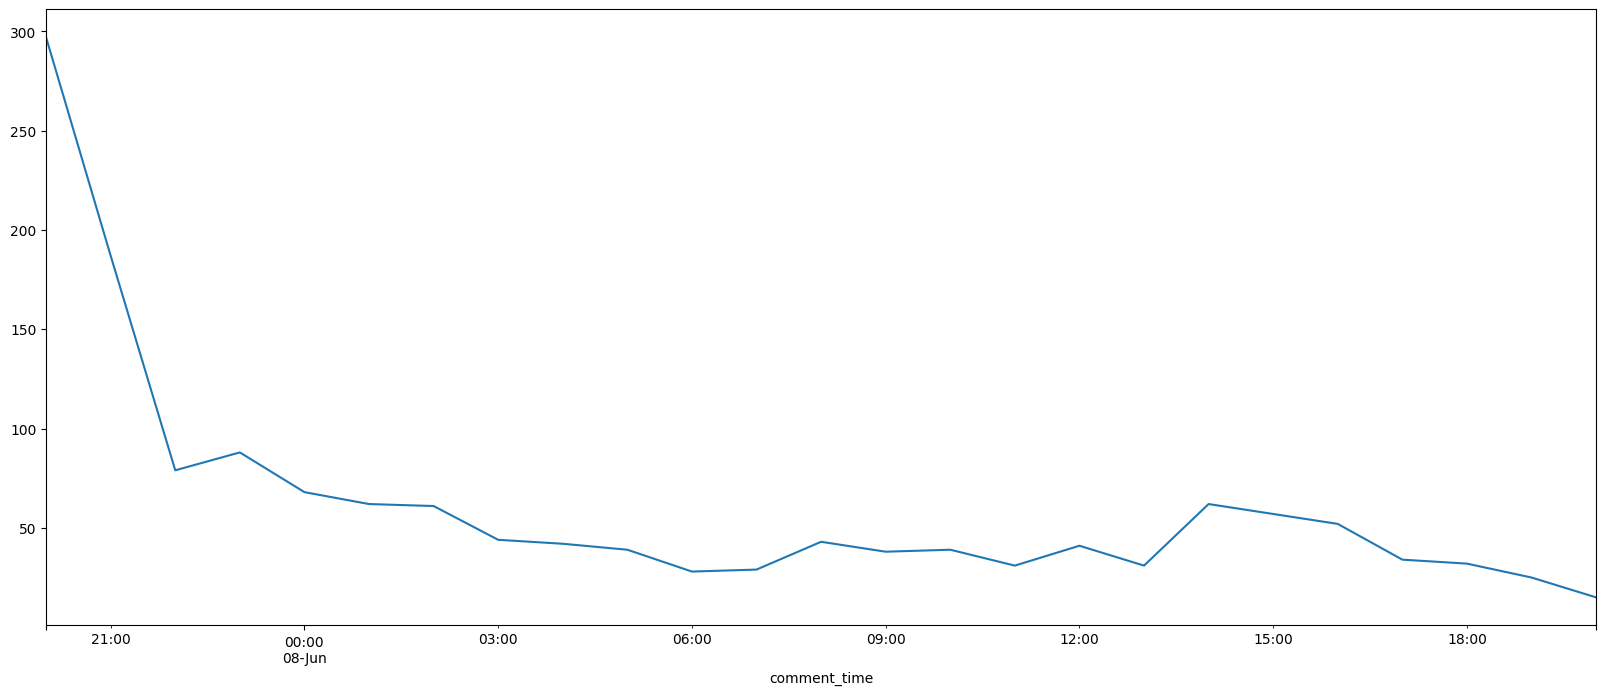

In [11]:
# plot the number of comments made in each hour of each day
all_comments_df.groupby(all_comments_df['comment_time'].dt.to_period('h')).count()['comment'].plot(figsize=(20,8))

In [12]:
# function to print some visualizations of a user's comments
def user_details(username, comments_df):
    user_comments = comments_df[comments_df['user'] == username].drop('user', axis=1)
    
    # create a DataFrame that only contains the hours of the day
    comments_per_hour = pd.DataFrame({'comment_time': range(24)})
    
    # create a DataFrame that has the hour of the day column and a comment count column by grouping by hour of day, then counting the comments for each hour
    user_comments_per_hour = user_comments.groupby(user_comments['comment_time'].dt.hour).count()['comment'].reset_index()
    
    # add the comments per hour column by merging the two DataFrames
    comments_per_hour = pd.merge(comments_per_hour, user_comments_per_hour, on='comment_time', how='outer').fillna(value=0)
    
    # plot a bar graph
    sns.set_style('darkgrid', rc={'grid.color': '.6', 'grid.linestyle': ':', 'xtick.bottom': True, 'ytick.left': True})
    
    fig, ax = plt.subplots(figsize=(20, 8))
    sns.barplot(comments_per_hour, x='comment_time', y='comment', hue='comment', palette='ch:s=.25,rot=-.25')
    ax.set(xlabel = 'Hour of Day', ylabel='Number of Comments', title='Number of Comments Per Hour of Day')
    #ax.set_yticks(range(0,51,5))
    plt.gca().legend().remove()
    plt.show()
    
    # create a DataFrame that has the number of comments per day
    user_comments_per_day = user_comments.groupby(user_comments['comment_time'].dt.date).count()['comment'].reset_index()
    
    # convert column back to datetime since the column created after the index was reset was converted to an object dtype
    user_comments_per_day['comment_time'] = pd.to_datetime(user_comments_per_day['comment_time'])
    
    # if the user commented on only one day, create a min_date and max_date of one day prior and one day after for visualization purposes
    if len(user_comments_per_day) == 1:
        min_date = pd.Timestamp(pd.to_datetime(user_comments_per_day['comment_time'] - pd.tseries.offsets.DateOffset(days=1))[0])
        max_date = pd.Timestamp(pd.to_datetime(user_comments_per_day['comment_time'] + pd.tseries.offsets.DateOffset(days=1))[0])
    else:
        # get the earliest and latest dates that the user posted comments on
        min_date = pd.Timestamp(min(user_comments_per_day['comment_time']))
        max_date = pd.Timestamp(max(user_comments_per_day['comment_time']))
    
    #create a range of dates
    date_range = pd.date_range(start=min_date, end=max_date, inclusive='both', freq='D')
    
    # create a DataFrame containing only a range of the dates
    comments_per_day = pd.DataFrame({'comment_time': date_range})
    
    # add the comments per day by merging the two DataFrames
    comments_per_day = pd.merge(comments_per_day, user_comments_per_day, on='comment_time', how='outer').fillna(value=0)
    
    # plot a line graph
    fig, ax = plt.subplots(figsize=(20, 8))
    sns.barplot(comments_per_day, x='comment_time', y='comment', hue='comment', palette='ch:s=.25,rot=-.25')
    ax.set(xlabel = 'Date', ylabel='Number of Comments', title='Number of Comments Per Day')
    plt.xticks(rotation=90)
    plt.gca().legend().remove()
    plt.show()

User name: @spider-manunknown9193 
Total comments: 47


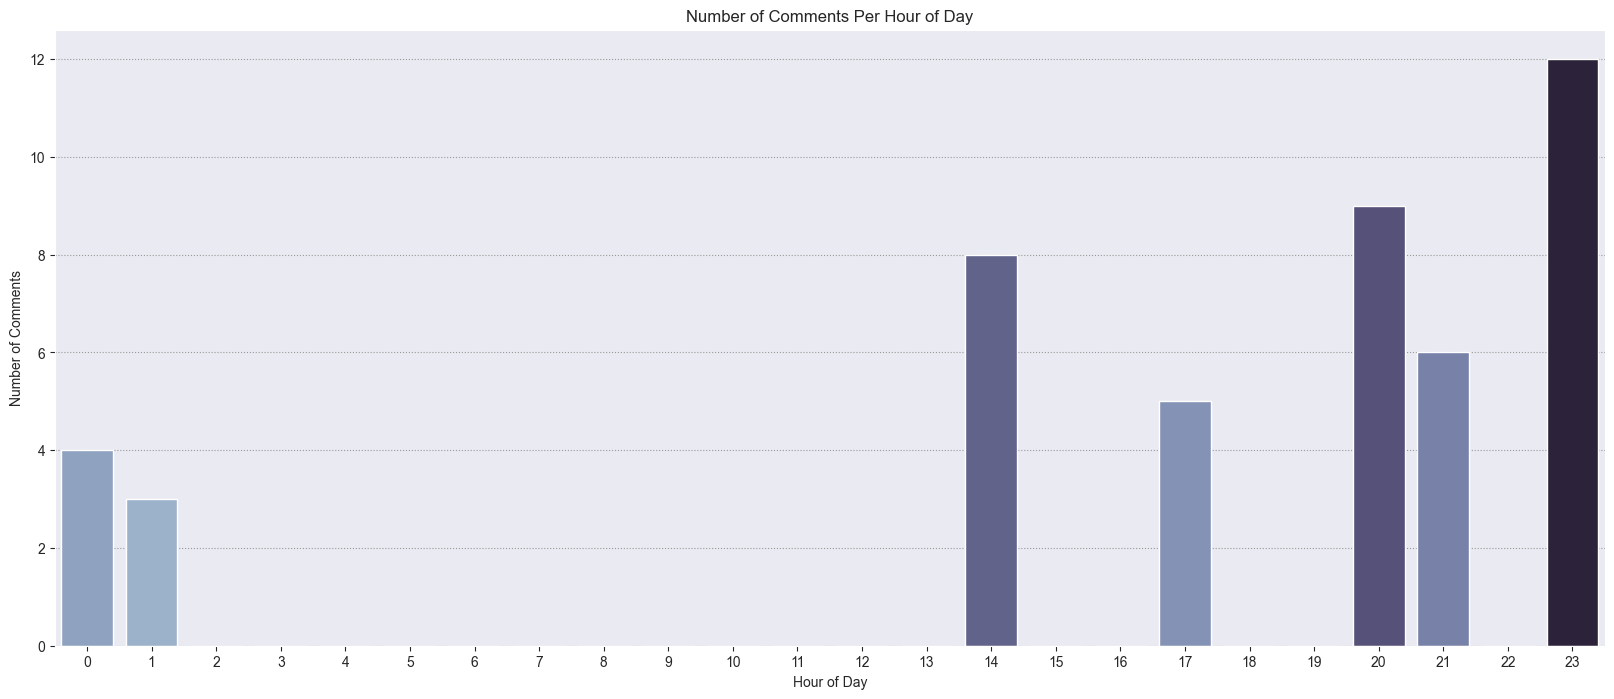

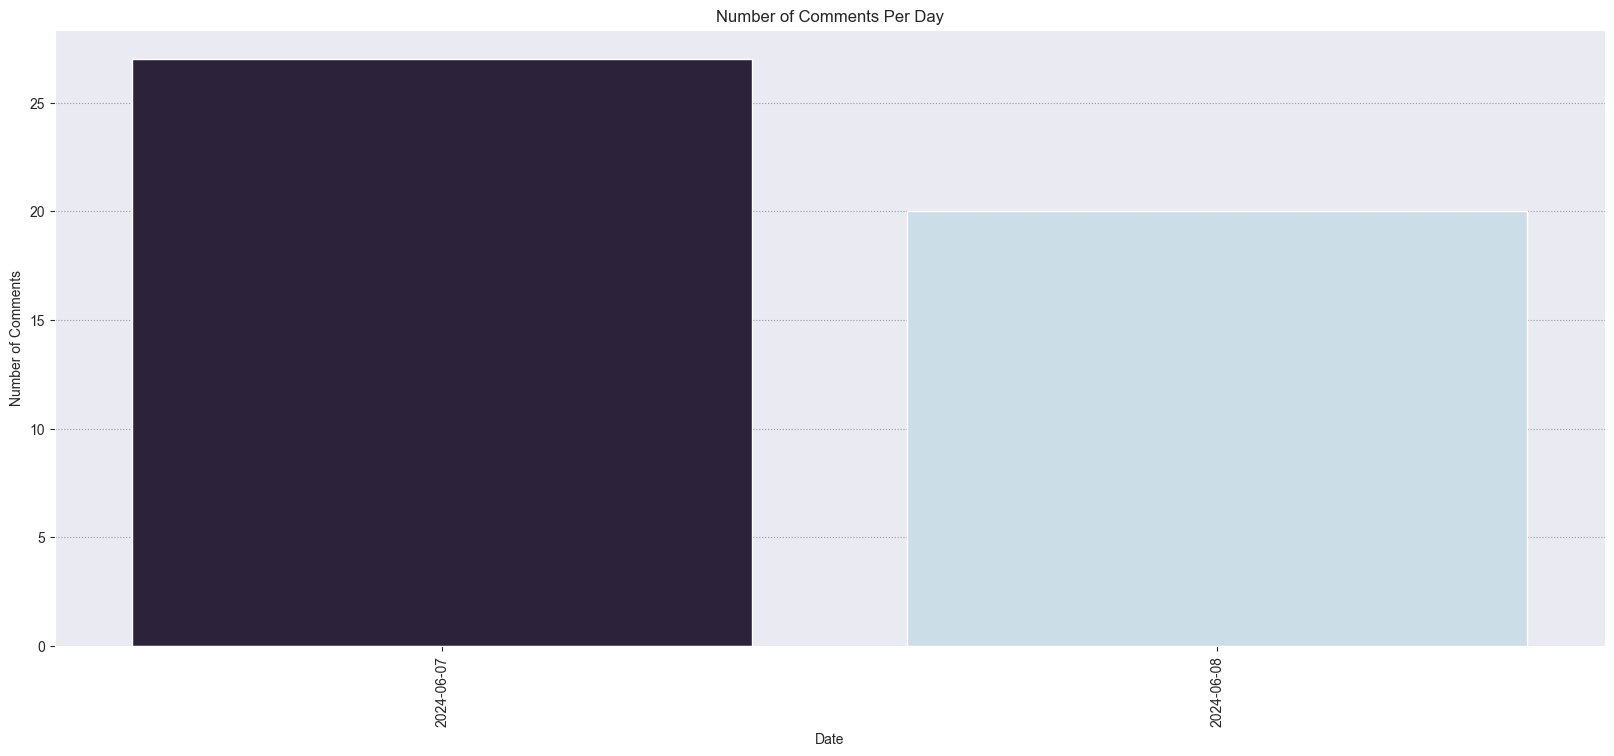

User name: @Yayofangamer16 
Total comments: 21


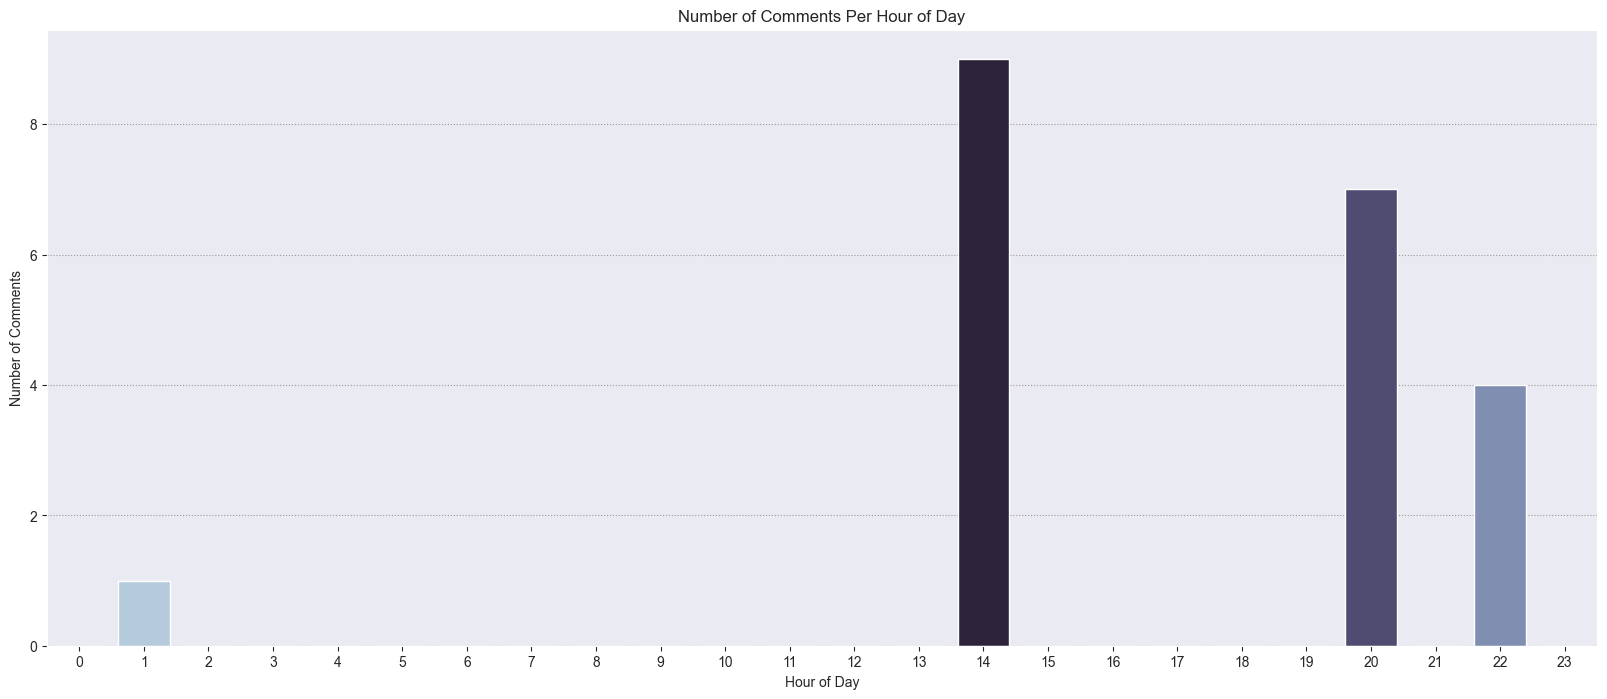

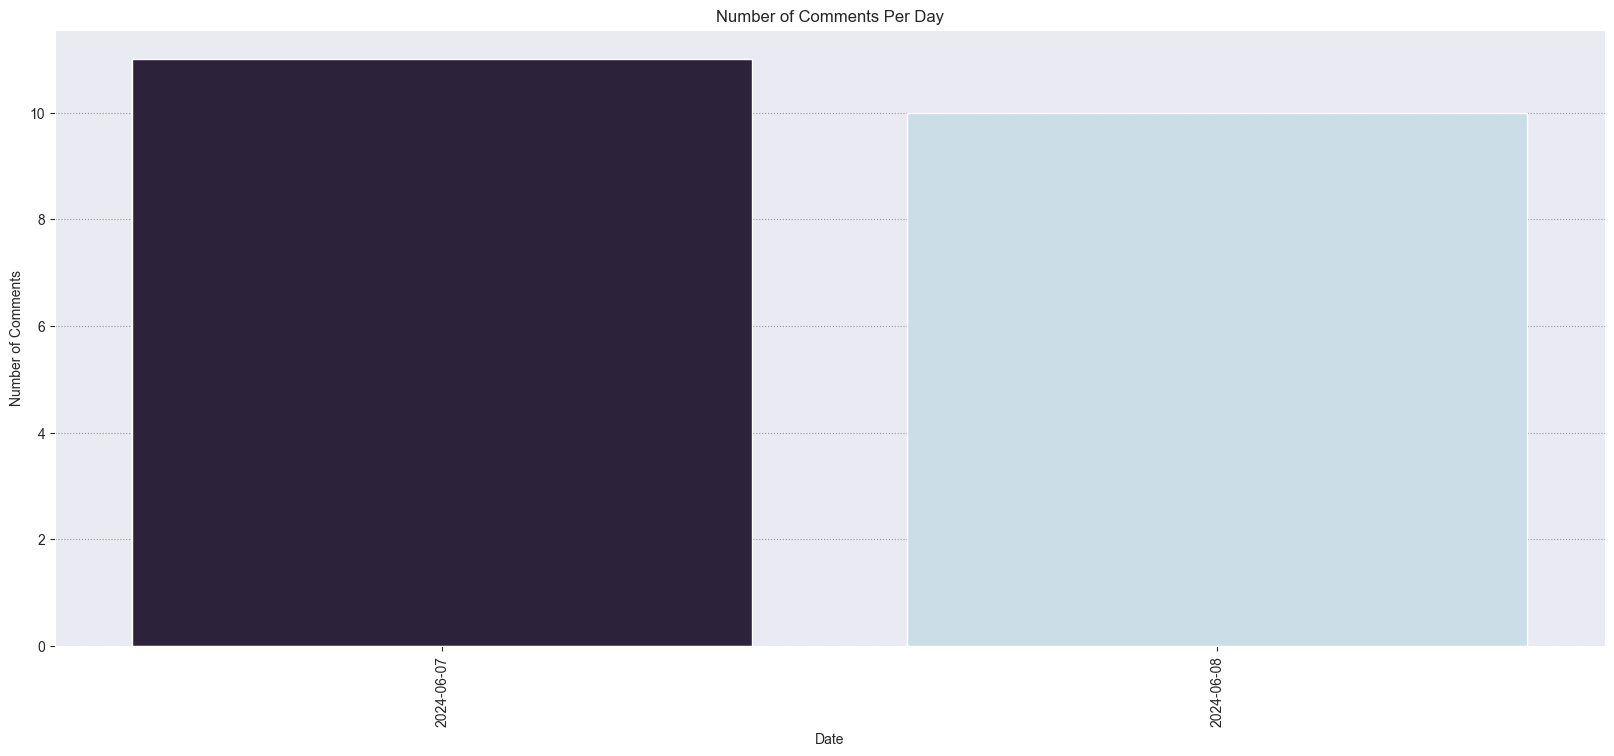

User name: @GangsterFrankensteinComputer 
Total comments: 19


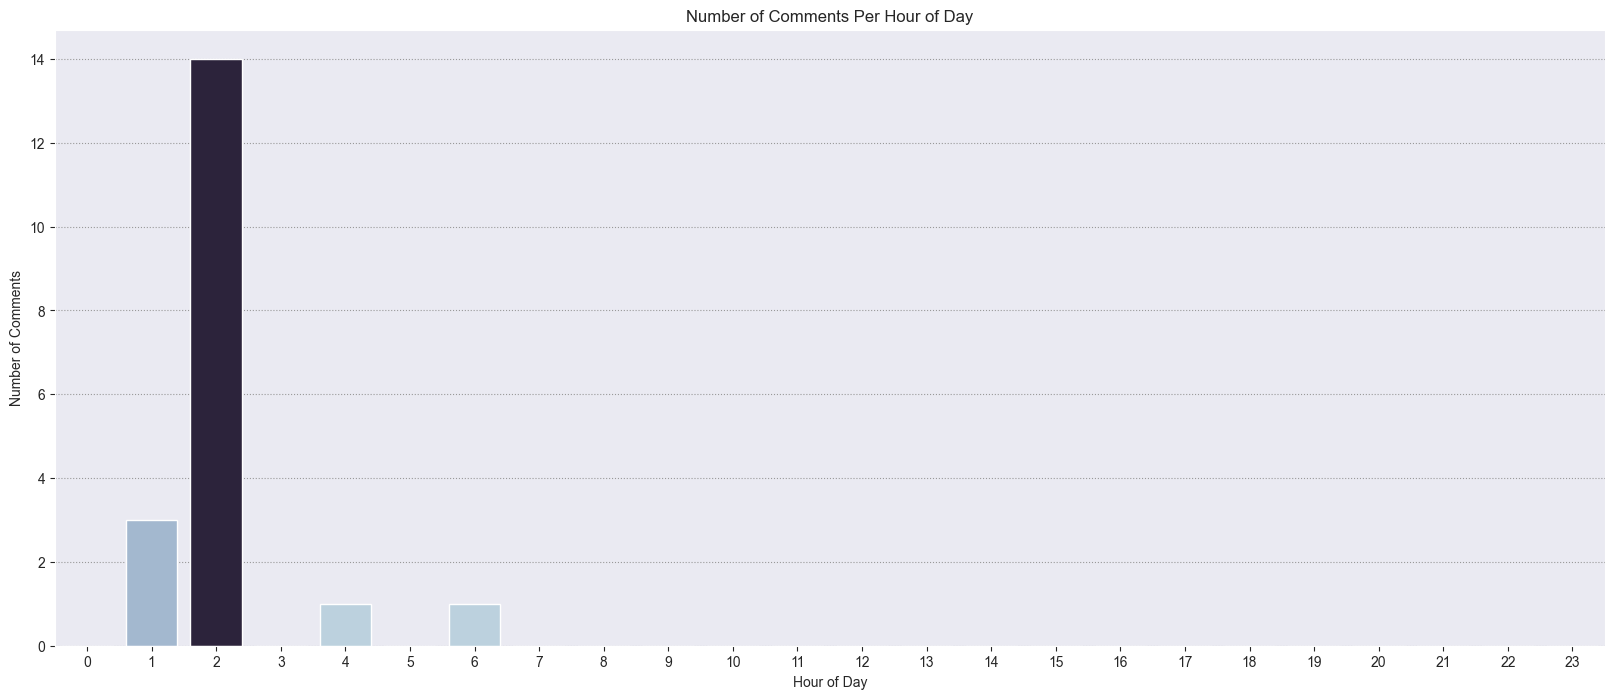

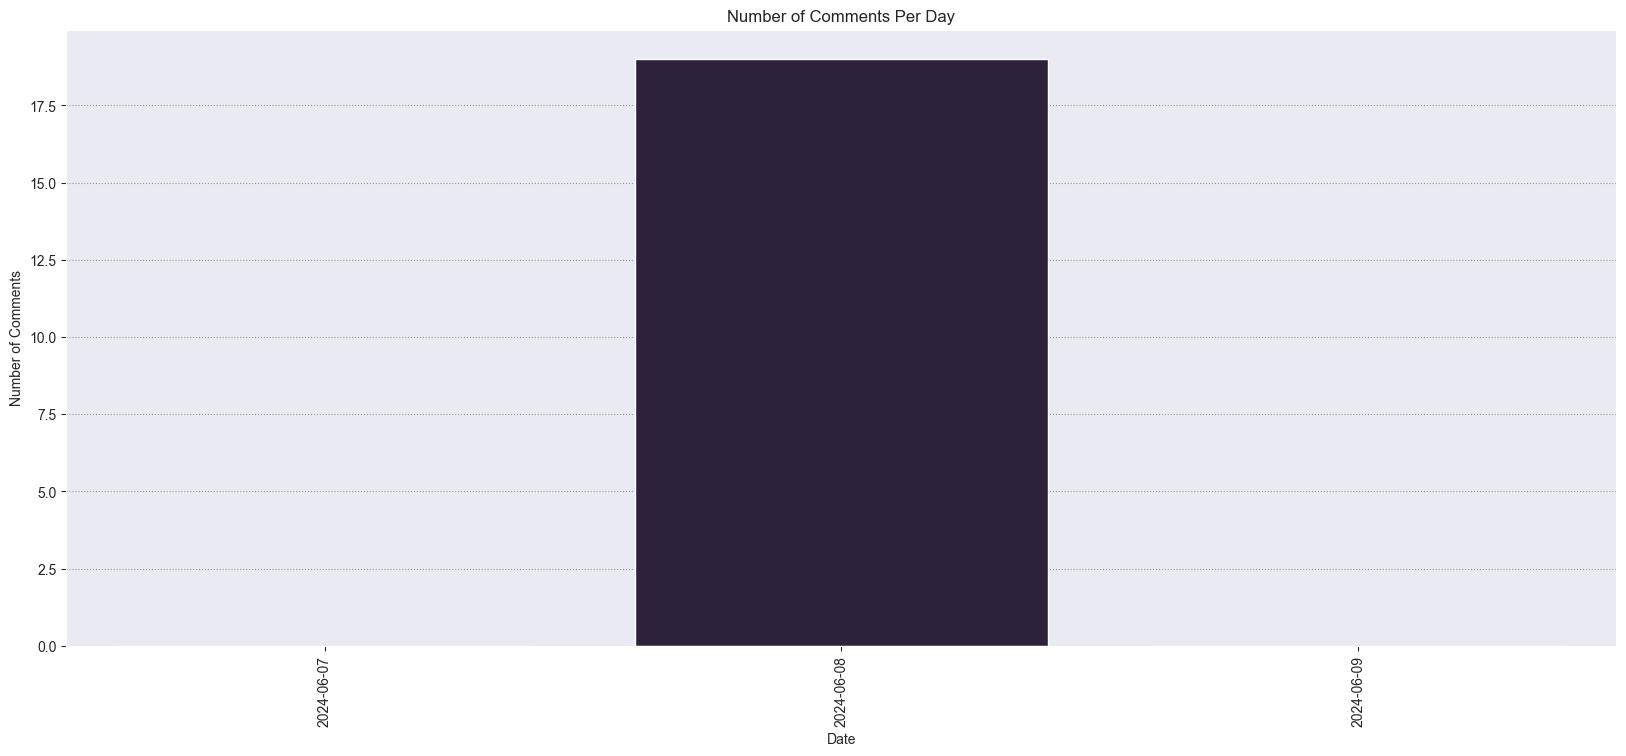

User name: @arkgaharandan5881 
Total comments: 18


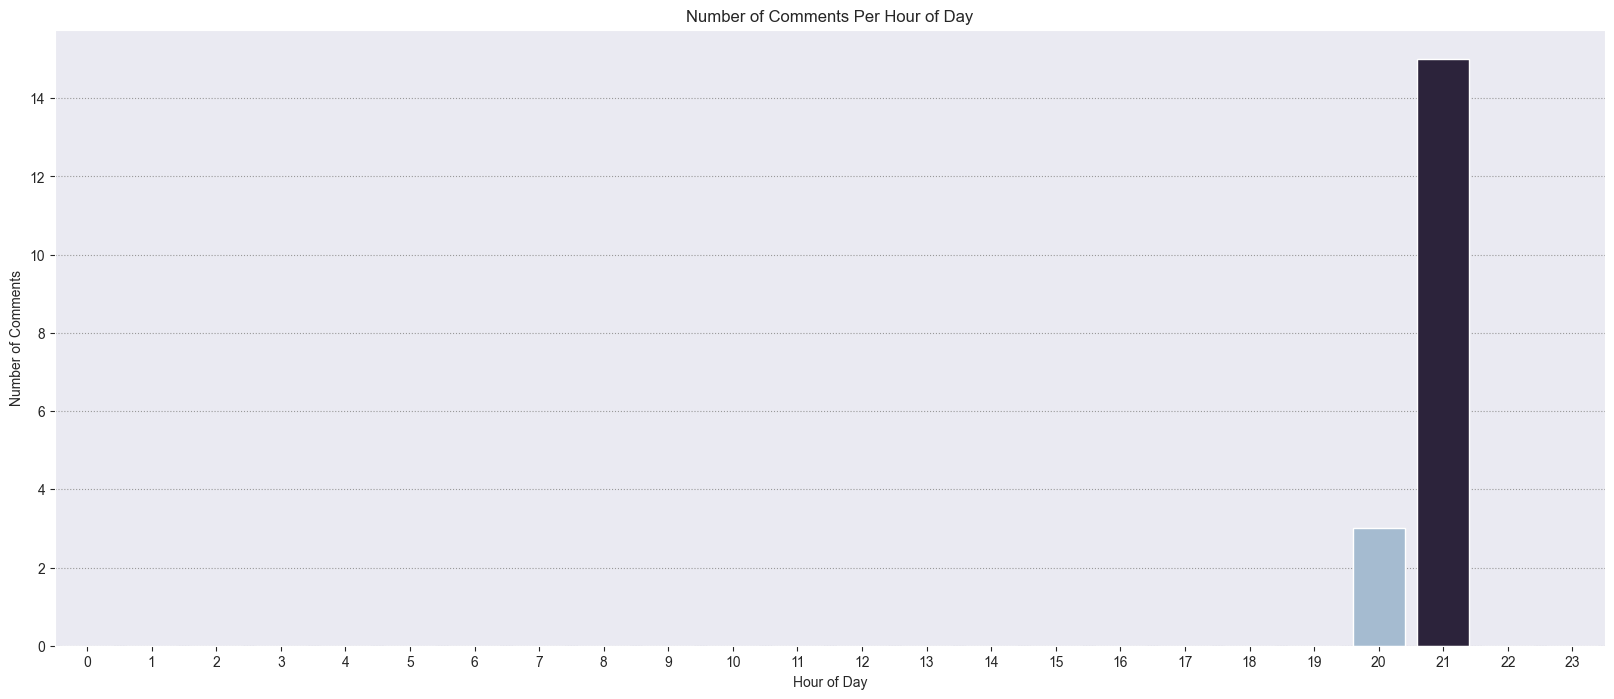

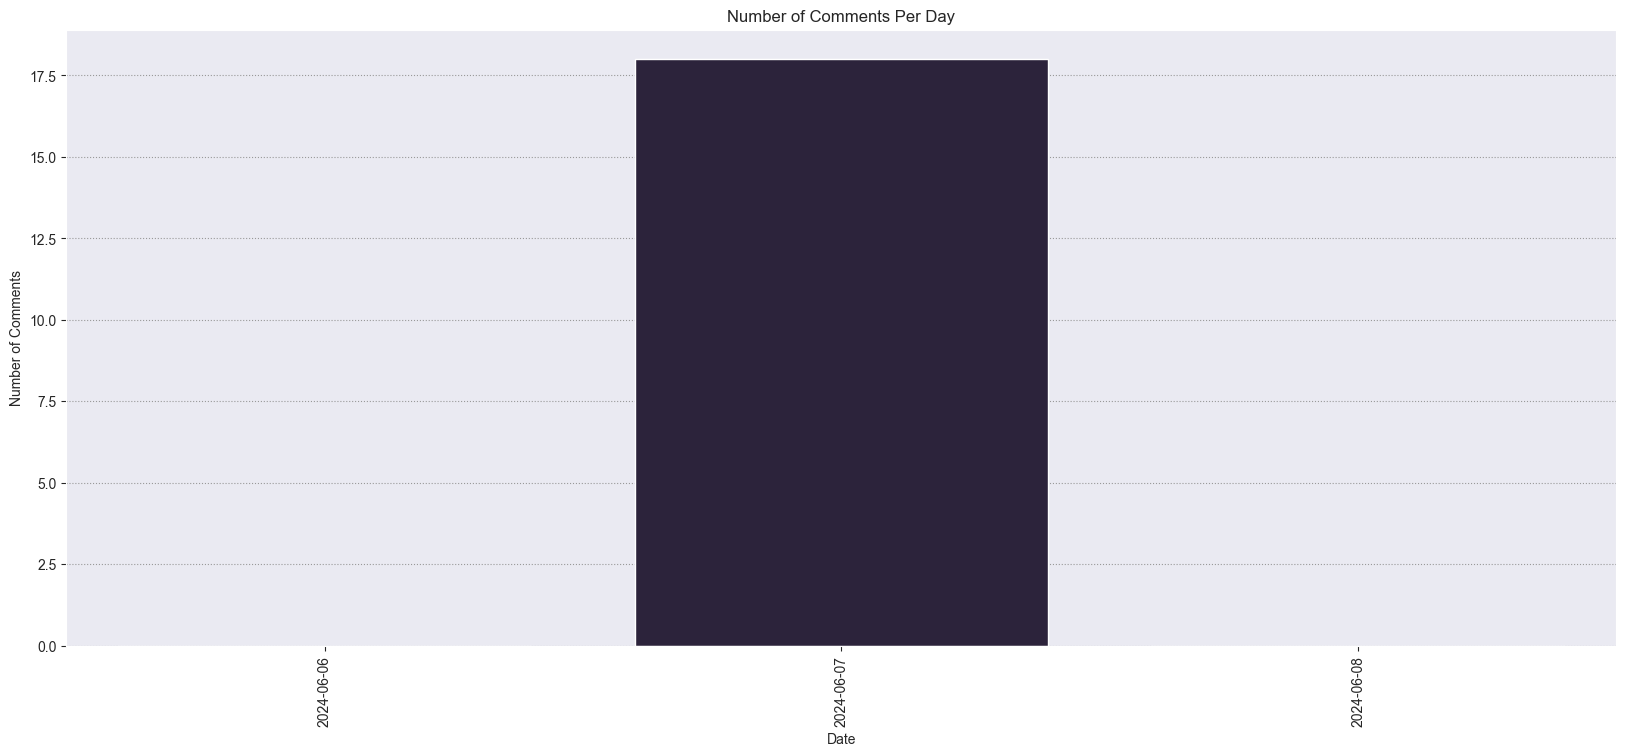

User name: @czarnakoza9697 
Total comments: 17


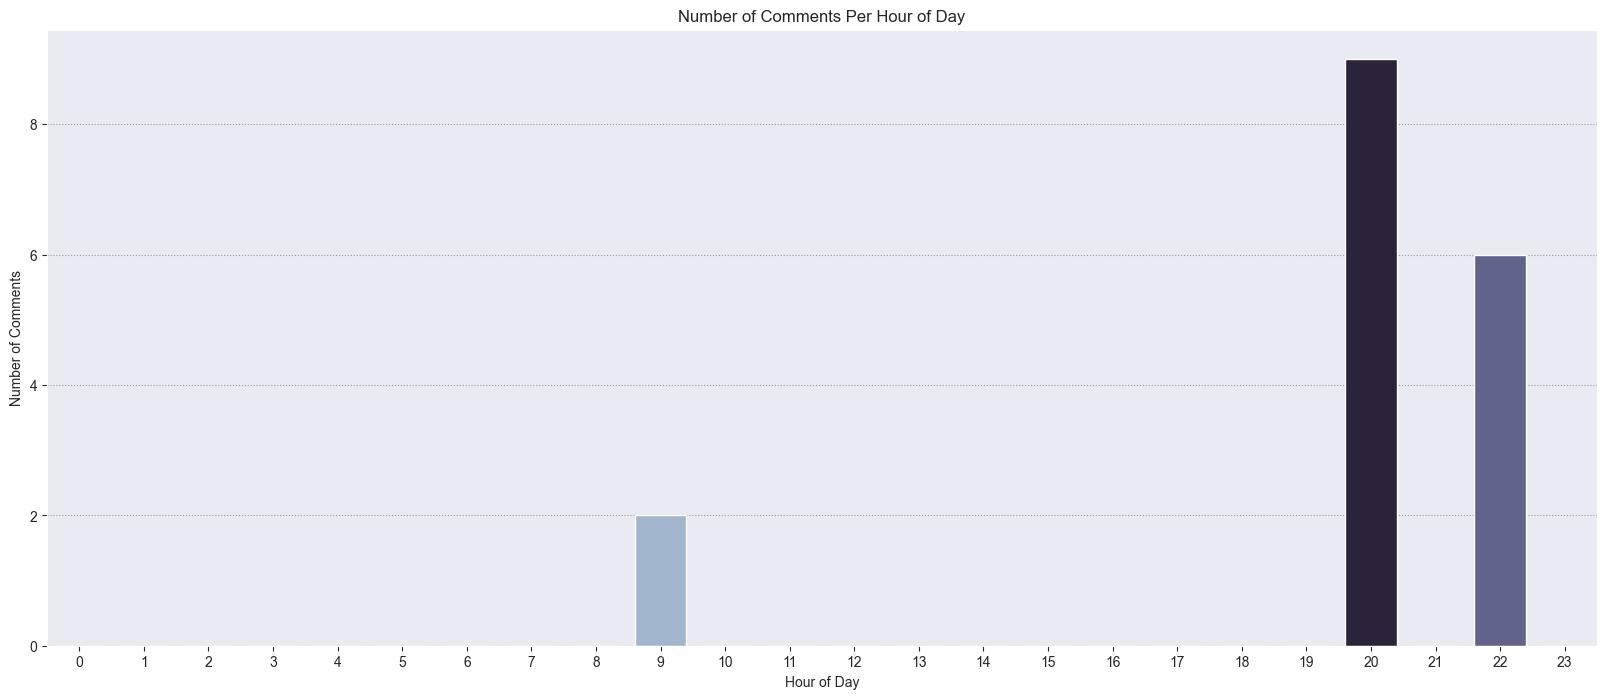

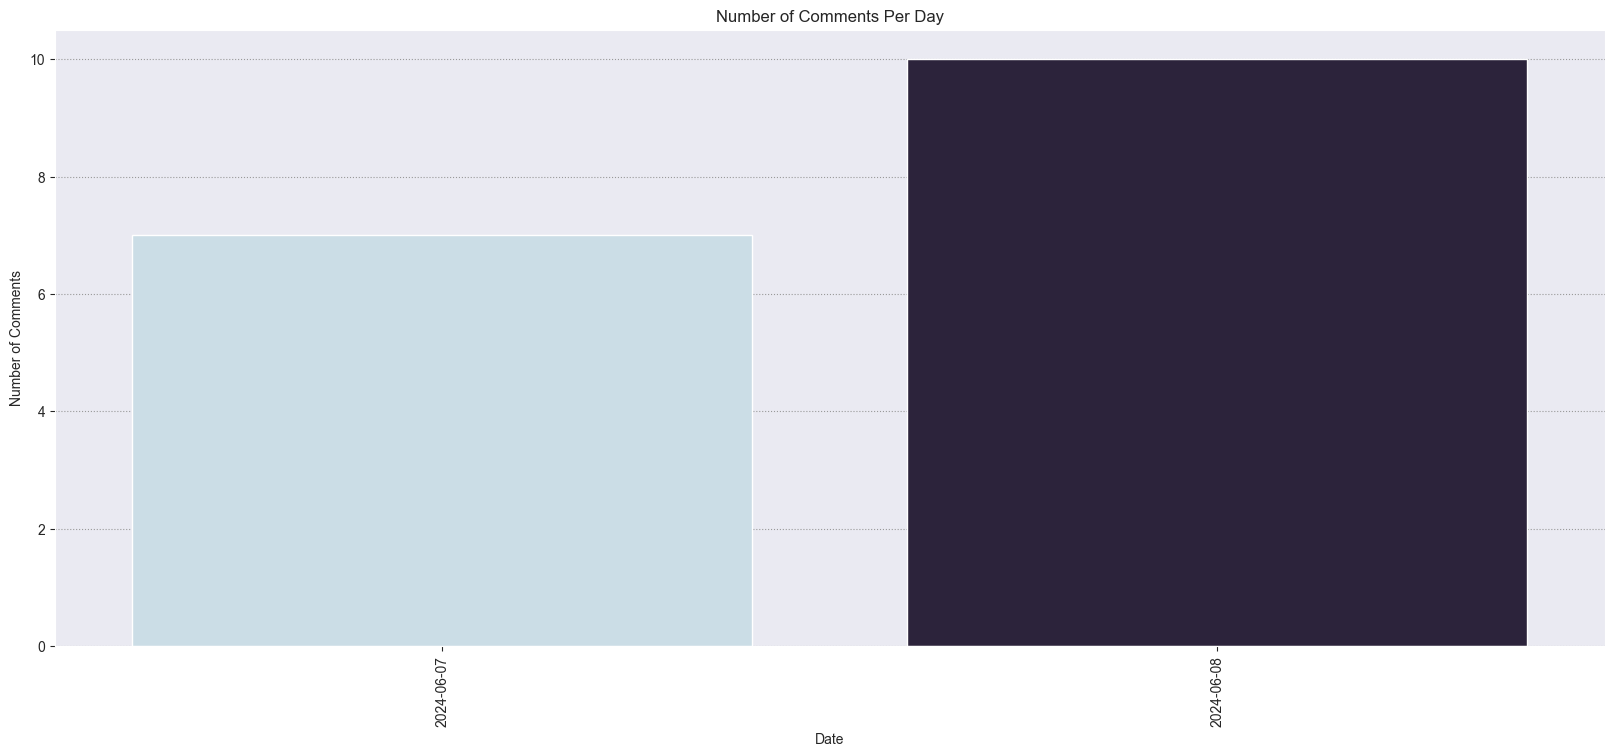

In [13]:
# print out graphs for the top 5 

for user in all_comments_df['user'].value_counts()[:5].index:
    print('User name:', user, '\nTotal comments:', (all_comments_df['user'] == user).sum())
    
    user_details(user, all_comments_df)

In [14]:
# looking at comments made in between the time of release and the earliest time at which the video would've been theoretically watched to completion

In [15]:
# get the API key from the .env file
load_dotenv()
api_key = os.getenv('API_KEY')

# insert the video ID from desired video to extract comments from (this would be the text that comes after 'https://www.youtube.com/watch?v=')
videoId = 'N1E045hiKB8'

# initiate the YouTube client
youtube = build(serviceName='youtube', version='v3', developerKey=api_key)

# create a request to get the parent comments, then save the response
request = youtube.videos().list(part='snippet', id=videoId)
response = request.execute()

In [16]:
# get the release date and time
release_date = pd.to_datetime(response['items'][0]['snippet']['publishedAt'])

In [17]:
# send a different kind of request to get the duration of the video

request = youtube.videos().list(part='contentDetails', id=videoId)
response = request.execute()

# save the video length
vid_length = pd.Timedelta(response['items'][0]['contentDetails']['duration'])

In [18]:
print(release_date)
print(vid_length)
print(release_date + vid_length)

2024-06-07 20:04:20+00:00
0 days 00:28:12
2024-06-07 20:32:32+00:00


In [19]:
# save the first comments within this window of time as a separate dataframe
all_comments_df[(all_comments_df['comment_time'] >= release_date) & (all_comments_df['comment_time']  <= (release_date + vid_length))]

,comment,comment_id,parent_comment,user,user_avatar,user_page,comment_time,likes,replies
466,white men are not allowed to enjoy anything yo...,UgxTP441iA4Jo5fpqUx4AaABAg,n/a,@ChudDin,https://yt3.ggpht.com/9ThEA4Xf0x8e6KjBwmCg7AyE...,http://www.youtube.com/@ChudDin,2024-06-07 20:32:32+00:00,3,0
467,Please play Morrowind with the paper map to na...,UgyhdVOzixtO1NLRQ5d4AaABAg,n/a,@HeyBuddays,https://yt3.ggpht.com/ytc/AIdro_nud7eqHqRdtSxU...,http://www.youtube.com/@HeyBuddays,2024-06-07 20:32:30+00:00,23,0
468,"The only truly excellent indie game, in both w...",UgwIFlWKHuPbPsZcHHl4AaABAg,n/a,@YamaikoHiro,https://yt3.ggpht.com/ytc/AIdro_mvCjDhUu6LRomU...,http://www.youtube.com/@YamaikoHiro,2024-06-07 20:32:15+00:00,44,6
469,"Not all indie games are great, but there’s exc...",Ugzimi82-bPzYl7PwdF4AaABAg,n/a,@ScytheJackal,https://yt3.ggpht.com/hKSdKsfbgdgAiok6Mpjv74K1...,http://www.youtube.com/@ScytheJackal,2024-06-07 20:31:58+00:00,1,3
470,I just finished Parasite Eve 1 for the first t...,UgywGylq3d62KHrJCQ94AaABAg,n/a,@Dregomz02,https://yt3.ggpht.com/N50vp2zOnXH6EHLd2iZh6d6N...,http://www.youtube.com/@Dregomz02,2024-06-07 20:31:47+00:00,13,3
...,...,...,...,...,...,...,...,...,...
948,Hi gooners,UgxkydKsTPmD6ZvdYFl4AaABAg.A4OqqJtXDgKA4OrC7QQ8Gt,UgxkydKsTPmD6ZvdYFl4AaABAg,@jebreggie4225,https://yt3.ggpht.com/ytc/AIdro_ns4WmS22LOvvzB...,http://www.youtube.com/@jebreggie4225,2024-06-07 20:08:03+00:00,18,0
949,Good day,UgxkydKsTPmD6ZvdYFl4AaABAg.A4OqqJtXDgKA4OrLt-_jr5,UgxkydKsTPmD6ZvdYFl4AaABAg,@PerturbatorFan,https://yt3.ggpht.com/u1GCWKLprwMkvrVqgjOJtydt...,http://www.youtube.com/@PerturbatorFan,2024-06-07 20:09:23+00:00,3,0
950,Soy army reporting,UgxkydKsTPmD6ZvdYFl4AaABAg.A4OqqJtXDgKA4OrZO1OH5X,UgxkydKsTPmD6ZvdYFl4AaABAg,@H0mework,https://yt3.ggpht.com/ytc/AIdro_lL3a2p2kIBbgir...,http://www.youtube.com/@H0mework,2024-06-07 20:11:13+00:00,10,0
951,In regards of the video someone made about Syn...,UgxkydKsTPmD6ZvdYFl4AaABAg.A4OqqJtXDgKA4OrcAFCPoC,UgxkydKsTPmD6ZvdYFl4AaABAg,@Yayofangamer16,https://yt3.ggpht.com/cEu5T0LfQsfwHdCskaLpWIjx...,http://www.youtube.com/@Yayofangamer16,2024-06-07 20:11:44+00:00,11,0
